In [2]:
import json
import pygraphviz
from time import strftime
import networkx as nx
from networkx.readwrite import json_graph
from networkx.drawing import nx_agraph
import numpy as np
import smacofSphere
from scipy.sparse.csgraph import dijkstra
from sklearn import preprocessing

In [3]:
#Reading in the graph
dot_graph = nx_agraph.from_agraph(pygraphviz.AGraph("sample.dot"))


In [12]:
#Setting up the matrix for smacof

Gc = max(nx.connected_component_subgraphs(dot_graph), key=len)
g_mat = np.ones(shape=(len(Gc.nodes()),len(Gc.nodes())))
g_mat = 100*g_mat
n_list = list(Gc.nodes())
for e in Gc.edges():
    try:
        #Graph is weighted
        g_mat[n_list.index(e[0])][n_list.index(e[1])] = float(Gc.get_edge_data(e[0],e[1])[0]['weight'])
        g_mat[n_list.index(e[1])][n_list.index(e[0])] = float(Gc.get_edge_data(e[1],e[0])[0]['weight'])
    except:
        #Graph is unweighted
        g_mat[n_list.index(e[0])][n_list.index(e[1])] = 1.0
        g_mat[n_list.index(e[1])][n_list.index(e[0])] = 1.0
g_mat = np.asarray(g_mat)
g_mat = 1.1 - g_mat/np.max(g_mat)

In [13]:

#Finding the dissimilarity matrix
g_mat = dijkstra(g_mat)
end = 1 - (g_mat/np.max(g_mat))
np.fill_diagonal(end, 0)
#Ensuring the result is symmetric
end = (end + end.T)/2
# vals = nx.to_numpy_matrix(gmat, nodelist=Gc.nodes)

In [14]:
#Running smacof
res = smacofSphere.smacofSphere(g_mat, itmax = 1000)


In [15]:
#Converting to lat/long for gmap
#You probably don't need/want this

# pos_vals = {}
# nlist = list(Gc.nodes(data=True))
# for i in range(len(res)):
#         [x,y,z] = res[0][i]
#         lat = np.degrees(np.arcsin(z))*(180/np.pi)
#         print(lat)
#         if (x > 0):
#             lon = np.arctan(y/x)*(180/np.pi)
#         elif (y > 0):
#             lon = np.arctan(y/x)*(180/np.pi) + 180
#         else:
#             lon = np.arctan(y/x)*(180/np.pi) - 180
#         pos_vals[nlist[i][0]] = str(lat)+","+str(lon)

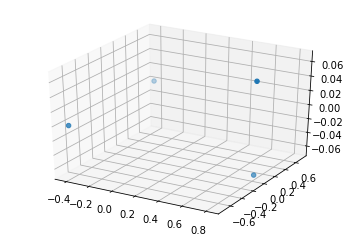

In [16]:
#Sanity check
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline 

res = np.asarray(res)

# print(np.real(res[0]))
ax = plt.axes(projection='3d')
ax.scatter(np.real(res[0][:,0]),np.real(res[0][:,1]),np.real(res[0][:,2]))


In [20]:
#Projecting and rotating

from math import cos, sin
coords2d = res[0]
def stereo(v):
#     R = np.linalg.norm([x,y,z])
    x,y,z = preprocessing.normalize(np.asarray(v).reshape(1, -1), norm='l2')[0]
    return [x/(1-z), y/(1-z)]
    
def inv_stereo(v):
    x = float(v[0])
    y = float(v[1])
    return [(2*x)/(1+x**2+y**2), (2*y)/(1+x**2+y**2), (x**2+y**2-1)/(1+x**2+y**2)]


def rotate_x(v,t):
    x = v[0]
    y = v[1]*cos(t) - v[2]*sin(t)
    z = v[1]*sin(t) + v[2]*cos(t)
    return (x,y,z)
def rotate_y(v,t):
    x = v[0]*cos(t) - v[2]*sin(t)
    y = v[1]
    z = v[0]*sin(t) + v[2]*cos(t)
    return (x,y,z)
def rotate_z(v,t):
    x = v[0]*cos(t) - v[1]*sin(t)
    y = v[0]*sin(t) + v[1]*cos(t)
    z = v[2]
    return(x,y,z)
def rotate(l):
    tx = np.random.uniform(low = 0, high = 2*np.pi)
    ty = np.random.uniform(low = 0, high = 2*np.pi)
    tz = np.random.uniform(low = 0, high = 2*np.pi)
    for x in range(len(l)):
        l[x] = rotate_z(rotate_y(rotate_x(l[x],tx),ty),tz)
    return l


#Setting up the new values for the dot product
coords = res[0]*100
for i in range(len(coords)):
    coords[i] = coords[i]/np.linalg.norm(coords[i])
coords = rotate(coords)


pos_vals = {}
h_vals = {}
w_vals = {}
id_vals = {}
for i in range(len(coords2d)):
    id_vals[Gc.nodes(data=True)[i][0]] = i
    pos_vals[Gc.nodes(data=True)[i][0]] = str(coords2d[i][0])+","+str(coords2d[i][1])
    h_vals[Gc.nodes(data=True)[i][0]] = 0.002#This should be changed eventually
    w_vals[Gc.nodes(data=True)[i][0]] = 0.002
nx.set_node_attributes(Gc, values = pos_vals, name = 'pos')
nx.set_node_attributes(Gc, values = h_vals, name = 'height')
nx.set_node_attributes(Gc, values = w_vals, name = 'width')
nx.set_node_attributes(Gc, values = id_vals, name = "id")

# print(Gc.nodes(data=True))

In [142]:
#More sanity checks

# import numpy as np

# def sample_spherical(npoints, ndim=3):
#     vec = preprocessing.normalize(np.random.randn(npoints, ndim))
#     vec = np.append(vec, [vec[0]], axis = 0)
#     return vec

# p = sample_spherical(5)
# # for x in p:
# #     print(x)
# p_proj = [stereo(x) for x in p]
# p_unproj = [inv_stereo(stereo(x)) for x in p]

# pr = True

# if(pr):
#     for x in range(len(p)):
#         print("POINT: ", x)
#         for j in range(len(p[x])):
#             print(p[x][j], p_unproj[x][j])
#         print(p_proj[x])
# #     print(p[x], p_proj[x], p_unproj[x])
# #     print(p[x] - p_unproj[x])
# # print(p, p_proj, p_unproj)
# # print(p, stereo(p))

('POINT: ', 0)
(-0.25214836267331436, -0.25214836267331436)
(0.1257058654477746, 0.12570586544777457)
(-0.9594890507938029, -0.9594890507938028)
[-0.12868066936692873, 0.06415236941326631]
('POINT: ', 1)
(0.19248739010107105, 0.19248739010107102)
(-0.6931230164322911, -0.6931230164322911)
(-0.694643137692931, -0.6946431376929308)
[0.11358579621850139, -0.40900824546216935]
('POINT: ', 2)
(-0.21074710589057702, -0.21074710589057705)
(0.9474305555670747, 0.9474305555670747)
(0.24075090807016716, 0.24075090807016722)
[-0.27757307599131587, 1.247852076001736]
('POINT: ', 3)
(-0.030765104106552046, -0.030765104106552053)
(0.9873540506136073, 0.9873540506136076)
(-0.15551683865811725, -0.1555168386581173)
[-0.026624539839920518, 0.8544696343501195]
('POINT: ', 4)
(-0.9591292859282113, -0.9591292859282113)
(-0.17309575929624033, -0.17309575929624033)
(-0.22385010830575341, -0.22385010830575336)
[-0.7836983299008647, -0.14143542425785036]
('POINT: ', 5)
(-0.25214836267331436, -0.25214836267331

[-0.36420664  0.30177326 -0.88662266 -0.34971795 -0.0589192  -0.36420664]


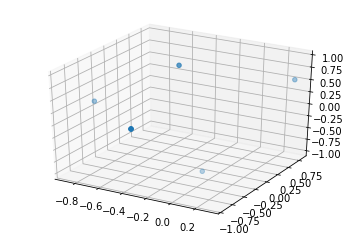

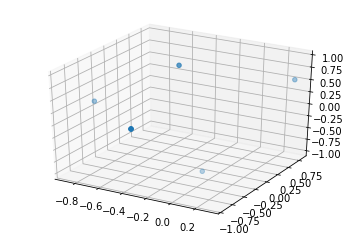

In [141]:
%matplotlib inline 

p = np.asarray(p)
p_proj =  np.asarray(p_proj)
p_unproj = np.asarray(p_unproj)
print(p[:,0])
# print(np.real(res[0]))
ax = plt.axes(projection='3d')
ax.scatter(p[:,0], p[:,1], p[:,2])
plt.show()

ax = plt.axes(projection='3d')
ax.scatter(p_unproj[:,0], p_unproj[:,1], p_unproj[:,2])
plt.show()